In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import sklearn

from src.data.some_dataloader import RedditDataset

dataset = RedditDataset()
df = dataset.data
#title = RedditDataset("data/soc-redditHyperlinks-title.tsv").data
#body = RedditDataset("data/soc-redditHyperlinks-body.tsv").data

#### Sentiment Ratio

LINK_SENTIMENT year_month   -1     1  ratio_per_month
0                 2013-12    2    12         6.000000
1                 2014-01  662  8218        12.413897
2                 2014-02  660  8202        12.427273
3                 2014-03  924  9842        10.651515
4                 2014-04  774  9206        11.894057


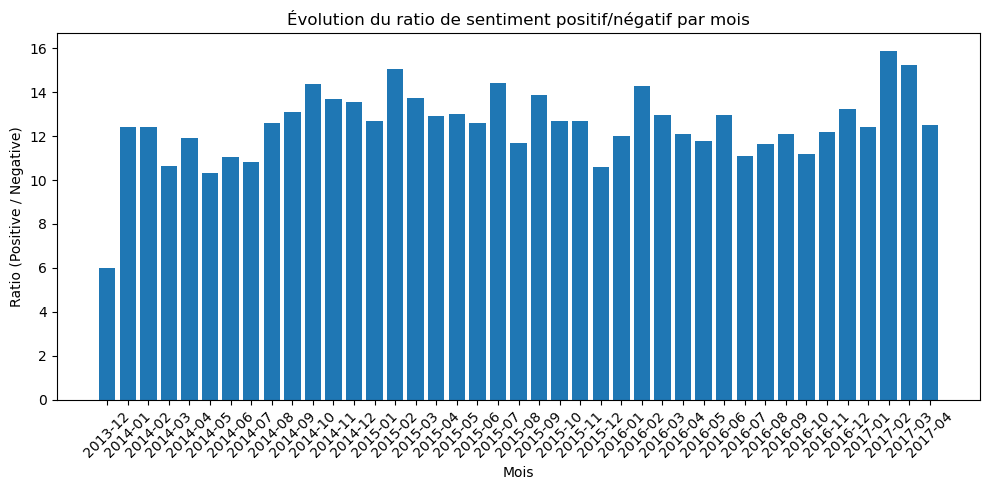

In [31]:
title = RedditDataset("data/soc-redditHyperlinks-title.tsv").data
body = RedditDataset("data/soc-redditHyperlinks-body.tsv").data
## ratio positive / negative
title['year_month'] = title['TIMESTAMP'].dt.to_period('M')
body['year_month'] = body['TIMESTAMP'].dt.to_period('M')


monthly_counts = body.groupby(['year_month', 'LINK_SENTIMENT']).size().unstack(fill_value=0)
monthly_counts['ratio_per_month'] = monthly_counts[1] / monthly_counts[-1]
ratio = monthly_counts.reset_index()

print(ratio.head())

plt.figure(figsize=(10,5))
plt.bar(ratio['year_month'].astype(str),ratio['ratio_per_month'])
plt.xticks(rotation=45)
plt.xlabel('Mois')
plt.ylabel('Ratio (Positive / Negative)')
plt.title('Évolution du ratio de sentiment positif/négatif par mois')
plt.tight_layout()
plt.show()

**Filter the most active subreddits**

In [32]:
# Count total activity (as source or target)
activity_counts = df['SOURCE_SUBREDDIT'].value_counts() + df['TARGET_SUBREDDIT'].value_counts()

# Keep top 500 most active subreddits
top_subreddits = activity_counts.nlargest(500).index

# Filter dataset
df_filtered = df[
    df['SOURCE_SUBREDDIT'].isin(top_subreddits) &
    df['TARGET_SUBREDDIT'].isin(top_subreddits)
]

**Create the gragh**

- whole dataset
- filtered dataset

In [42]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges with sentiment as an edge attribute
for _, row in df.iterrows():
    G.add_edge(
        row['SOURCE_SUBREDDIT'],
        row['TARGET_SUBREDDIT'],
        sentiment=row['LINK_SENTIMENT']
    )

# Graph with the filtered dataset

G_= nx.from_pandas_edgelist(
    df_filtered,
    source='SOURCE_SUBREDDIT',
    target='TARGET_SUBREDDIT',
    edge_attr='LINK_SENTIMENT',
    create_using=nx.DiGraph()
)

**Visualization of the graph (with a small sample)**

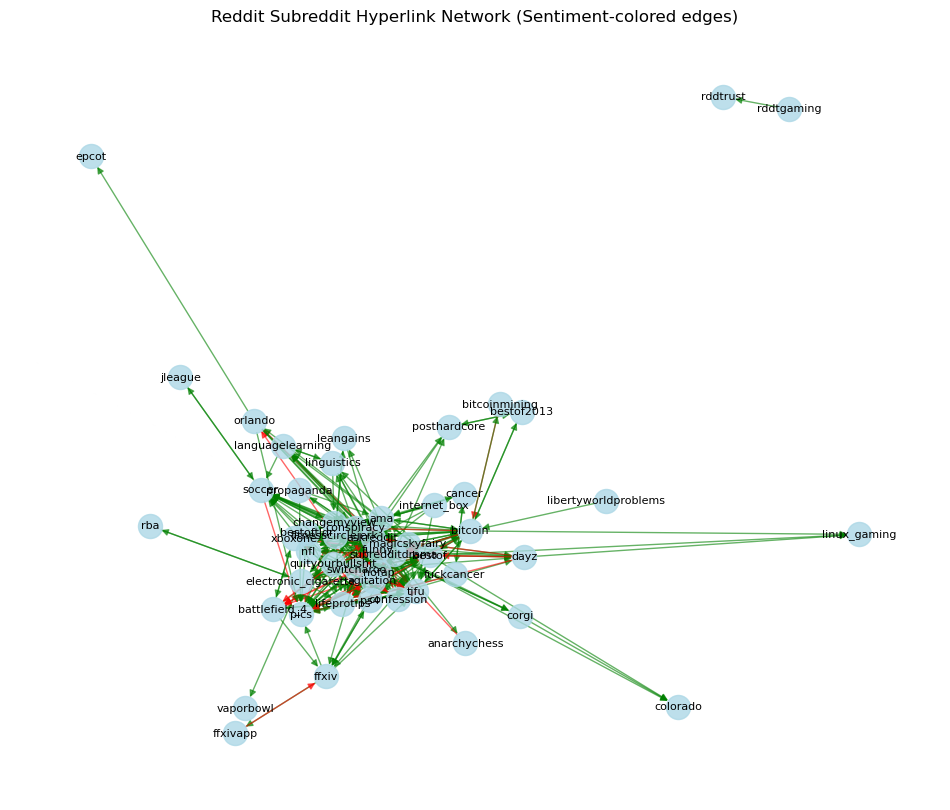

In [43]:

# Optional: take a subset of nodes
subgraph_nodes = list(G.nodes)[:50]  # first 50 subreddits
H = G.subgraph(subgraph_nodes)

# Color edges by sentiment
edge_colors = ['green' if G[u][v]['sentiment'] == 1 else 'red' for u, v in H.edges()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, seed=42, k=0.3)

nx.draw_networkx_nodes(H, pos, node_size=300, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, arrows=True, alpha=0.6)
nx.draw_networkx_labels(H, pos, font_size=8)

plt.title("Reddit Subreddit Hyperlink Network (Sentiment-colored edges)")
plt.axis("off")
plt.show()


#### Clustering with KMeans 

The goal is to cluster the subreddits by their graph-based features similarities (i.e. degree, pagerank...)

These capture the position of a subreddit within the social graph.

For example:

High betweenness → acts as a bridge between communities

High pagerank → highly influential node

Low clustering → more isolated or fringe

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Precompute metrics only once
pagerank_dict = nx.pagerank(G_)
clustering_dict = nx.clustering(G_.to_undirected())
betweenness_centrality_dict = nx.betweenness_centrality(G_)
closeness_centrality_dict = nx.closeness_centrality(G_)

# Build features efficiently
features = pd.DataFrame({
    'subreddit': list(G_.nodes()),
    'degree': [G_.degree(n) for n in G_.nodes()],
    'in_degree': [G_.in_degree(n) for n in G_.nodes()],
    'out_degree': [G_.out_degree(n) for n in G_.nodes()],
    'clustering': [clustering_dict[n] for n in G_.nodes()],
    'pagerank': [pagerank_dict[n] for n in G_.nodes()],
    'betweenness': [betweenness_centrality_dict[n] for n in G_.nodes()],
    'closeness': [closeness_centrality_dict[n] for n in G_.nodes()],
})

# Normalize features
X = features[['degree', 'in_degree', 'out_degree', 'clustering', 'pagerank']]
X_scaled = StandardScaler().fit_transform(X)

# Cluster subreddits
N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)


# --- Mean sentiment per subreddit ---
# Each subreddit may appear as SOURCE or TARGET, so we consider both
mean_sentiment = df_filtered.groupby('SOURCE_SUBREDDIT')['LINK_SENTIMENT'].mean()

# Convert to DataFrame and merge
sentiment_df = mean_sentiment.reset_index()
sentiment_df.columns = ['subreddit', 'mean_sentiment']

# Merge into features
features = features.merge(sentiment_df, on='subreddit', how='left')

# --- Variance of sentiment within each cluster ---
cluster_variance = features.groupby('cluster')['mean_sentiment'].var().reset_index()
cluster_variance.columns = ['cluster', 'sentiment_variance']

print("Variance of mean sentiment within each cluster:")
print(cluster_variance)

# Add cluster variance to features if useful
features = features.merge(cluster_variance, on='cluster', how='left')

# Inspect enriched feature table
features.head()



Variance of mean sentiment within each cluster:
   cluster  sentiment_variance
0        0            0.033464
1        1            0.012969
2        2            0.024281
3        3            0.000189
4        4            0.040830
5        5            0.027388
6        6            0.031901
7        7            0.100419
8        8            0.012832
9        9            0.018914


,subreddit,degree,in_degree,out_degree,clustering,pagerank,betweenness,closeness,cluster,mean_sentiment,sentiment_variance
0,fitnesscirclejerk,190,4,186,0.447491,0.000325,0.000235,0.416180,0,0.635029,0.033464
1,lifeprotips,250,201,49,0.427210,0.005377,0.001999,0.621420,2,0.719626,0.024281
2,bestoftldr,91,2,89,0.513797,0.000304,0.000004,0.327213,6,0.605229,0.031901
3,tifu,316,254,62,0.384535,0.006670,0.003840,0.665333,1,0.871658,0.012969
4,quityourbullshit,214,98,116,0.487101,0.001619,0.002198,0.541802,0,0.426573,0.033464


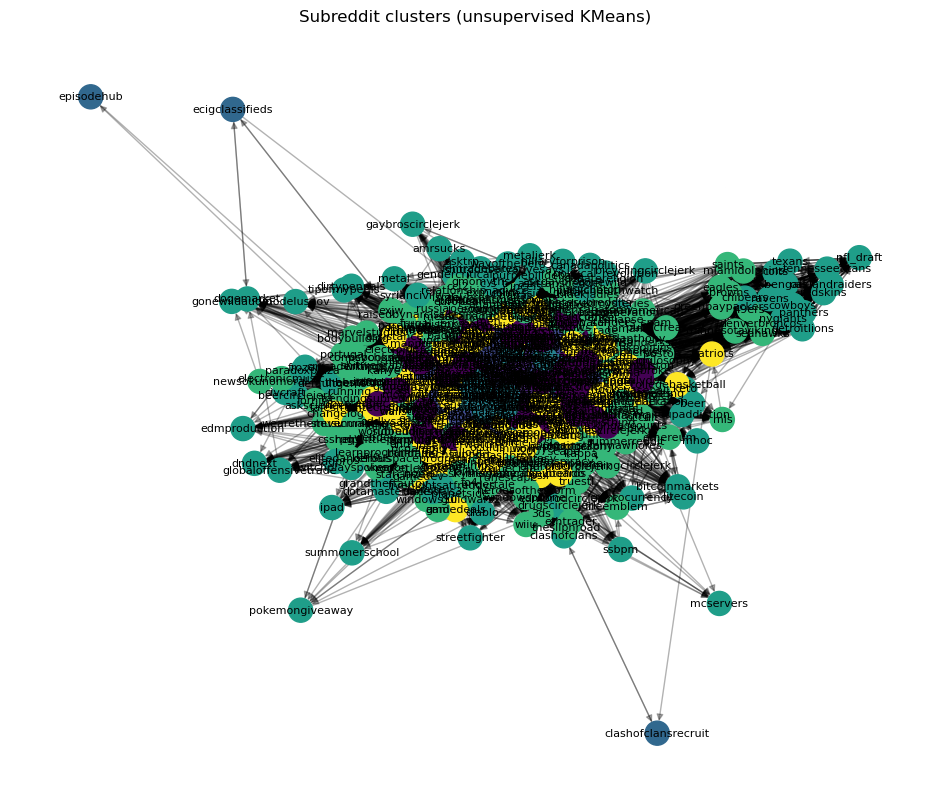

In [49]:
## Visualize clusters with KMeans

pos = nx.spring_layout(G_, seed=42, k=0.3)
node_colors = [features.set_index('subreddit').loc[n, 'cluster'] for n in G_.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_, pos, node_size=300, node_color=node_colors, cmap='viridis')
nx.draw_networkx_edges(G_, pos, alpha=0.3)
nx.draw_networkx_labels(G_, pos, font_size=8)

plt.title("Subreddit clusters (unsupervised KMeans)")
plt.axis("off")
plt.show()


In [50]:
for i in range(N_CLUSTERS):
    print(f"\nCluster {i}:")
    print(features[features['cluster'] == i]['subreddit'].head(10).tolist())


Cluster 0:
['fitnesscirclejerk', 'quityourbullshit', 'agitation', 'vegan', 'metacanada', 'notcirclejerk', 'panichistory', 'mensrights', 'libertarian', 'retiredgif']

Cluster 1:
['tifu', 'adviceanimals', 'worldnews', 'technology', 'movies', 'science', 'politics', 'mildlyinteresting', 'gaming', 'explainlikeimfive']

Cluster 2:
['lifeprotips', 'nfl', 'changemyview', 'trees', 'india', 'dogecoin', 'nottheonion', 'atheism', 'photoshopbattles', 'cringe']

Cluster 3:
['ecigclassifieds', 'episodehub', 'clashofclansrecruit']

Cluster 4:
['switcharoo', 'circlebroke2', 'shitamericanssay', 'shitstatistssay', 'depthhub', 'badphilosophy', 'circlebroke', 'shitpost', 'worstof', 'evenwithcontext']

Cluster 5:
['lostgeneration', 'defaultgems', 'drugscirclejerk', 'civcraft', 'shitrconservativesays', 'cryptocurrency', 'canadapolitics', 'oaklandraiders', 'keto', 'purplepilldebate']

Cluster 6:
['bestoftldr', 'nofap', 'worldpolitics', 'protectandserve', 'boston', 'childfree', 'privacy', 'shittyaskscience', 

/var/folders/mq/9dgjq8td63j1__v01jkv6z7c0000gn/T/ipykernel_46208/440161561.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=features, x='cluster', y='mean_sentiment', ci='sd', palette='viridis')
/var/folders/mq/9dgjq8td63j1__v01jkv6z7c0000gn/T/ipykernel_46208/440161561.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features, x='cluster', y='mean_sentiment', ci='sd', palette='viridis')


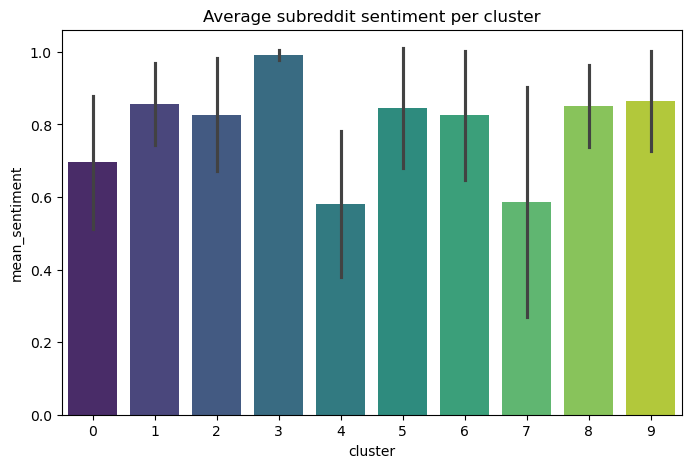

In [51]:
# Visualize average sentiment per cluster with standard deviation

plt.figure(figsize=(8,5))
sns.barplot(data=features, x='cluster', y='mean_sentiment', ci='sd', palette='viridis')
plt.title('Average subreddit sentiment per cluster')
plt.show()


Some clusters have subreddits with similar sentiment mean but some other have spread value.